### **Set working environment** 

In [1]:
# Install Spark NLP from PyPI
!pip install -q spark-nlp==4.0.1 pyspark==3.3.0

To enable Spark session on Google Cloud Vertex AI Workbench Jupyterlab Notebook, follow the steps as follows or refer [here](https://stackoverflow.com/questions/73047089/how-to-start-spark-session-on-vertex-ai-workbench-jupyterlab-notebook/73061535?noredirect=1#comment129061260_73061535).

Sign in to Google Cloud Platform [here](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwiT9svnmaX5AhVl7jgGHfxgBQYQFnoECAUQAQ&url=https%3A%2F%2Fconsole.cloud.google.com%2F&usg=AOvVaw1GxwHR1WZnDu0xsR-djCrv). Upon sign-in, on the Google Cloud console mainpage, go to ARTIFICIAL INTELLIGENCE section from the Navigation menu (denoted by 3 short horizontal solid lines) on the left panel and select Vertex AI then select Workbench. 
<br>Next, select USER-MANAGED-NOTEBOOK tab on the top panel to create Jupyterlab notebook. 
<br>Follow the following steps inside the notebook after creating the notebook. That is,
go to File->New->Terminal and run the following two commands in the Terminal:
<br>`sudo apt-get update`
<br>`sudo apt-get install default-jdk`

Lastly, verify if Java is installed with version by running this command: `java --version`.

In [2]:
import time

import sparknlp
from sparknlp.base import *
from sparknlp.common import *
from sparknlp.annotator import *

from pyspark.sql import functions as func
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession

# https://github.com/JohnSnowLabs/spark-nlp
# Start spark session
spark=sparknlp.start()

print("Spark NLP version: ", sparknlp.version())
print("Apache Spark version: ", spark.version)

spark

:: loading settings :: url = jar:file:/opt/conda/lib/python3.7/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/jupyter/.ivy2/cache
The jars for the packages stored in: /home/jupyter/.ivy2/jars
com.johnsnowlabs.nlp#spark-nlp_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-a8b0cede-0786-499c-aebd-9282070808e9;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp_2.12;4.0.1 in central
	found com.typesafe#config;1.4.2 in central
	found org.rocksdb#rocksdbjni;6.29.5 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.828 in central
	found com.github.universal-automata#liblevenshtein;3.0.0 in central
	found com.google.code.findbugs#annotations;3.0.1 in central
	found net.jcip#jcip-annotations;1.0 in central
	found com.google.code.findbugs#jsr305;3.0.1 in central
	found com.google.protobuf#protobuf-java-util;3.0.0-beta-3 in central
	found com.google.protobuf#protobuf-java;3.0.0-beta-3 in central
	found com.google.code.gson#gson;2.3 in central
	found it.unimi.dsi#fastutil;7.0.12 in central
	found org.projectlombok#l

22/08/03 21:32:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/08/03 21:32:06 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
Spark NLP version:  4.0.1
Apache Spark version:  3.3.0


In [3]:
# https://stackoverflow.com/questions/36786722/how-to-display-full-output-in-jupyter-not-only-last-result
# Display full output in output cell, not only last result
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [4]:
import pandas as pd

# https://www.kaggle.com/questions-and-answers/118932
# Max rows and columns of pandas dataframe 
pd.options.display.max_rows,pd.options.display.max_columns

# https://thispointer.com/python-pandas-how-to-display-full-dataframe-i-e-print-all-rows-columns-without-truncation/
# Print all the contents of a pandas dataframe
pd.set_option('display.max_rows', None) # Print unlimited number of rows by setting to None, default is 10
pd.set_option('display.max_columns', None) # Do not truncate columns to display all of them by setting to None
pd.set_option('display.width', None) # Auto-detect the width of dataframe to display all columns in single line by setting to None
pd.set_option('display.max_colwidth', None) # Auto detect the max size of column and print contents of that column without truncated the contents

(60, 20)

### **Logistic Regression with TFIDF**
- TFIDF=Term frequency-inverse document frequency

#### **Pipeline, GridSearch and Cross Validation**

In [5]:
# https://stackoverflow.com/questions/8924173/how-to-print-bold-text-in-python
start = "\033[1m" # Bold text
end = "\033[0;0m" # Reset 

from pyspark.ml.feature import HashingTF, IDF
hashingTF = HashingTF(inputCol="token_features", outputCol="rawFeatures")
idf = IDF(inputCol="rawFeatures", outputCol="features") 

from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(labelCol='Recommended IND',weightCol='weightCol')

# Configure an ML pipeline, which consists of three stages:
pipeline_lr = Pipeline(stages=[hashingTF,idf,lr])

# Tuning the model with the ParamGridBuilder and the CrossValidator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Create ParamGrid for Cross Validation
paramGrid_lr = (ParamGridBuilder()
              .addGrid(hashingTF.numFeatures, [10,100,1000,10000])
              .addGrid(idf.minDocFreq, [2,5])  # minDocFreq: remove sparse terms
              .addGrid(lr.regParam, [0,0.01,0.3,0.5,2.0])
              .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) # [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty
              .addGrid(lr.maxIter, [1,5,10]) 
              .build())

from pyspark.ml.evaluation import BinaryClassificationEvaluator
binary_evaluator = BinaryClassificationEvaluator(labelCol='Recommended IND',metricName='areaUnderPR')

cv_lr = CrossValidator(estimator=pipeline_lr, 
                       estimatorParamMaps=paramGrid_lr, 
                       evaluator=binary_evaluator, 
                       numFolds=3,
                       parallelism=10,
                       seed=42) # https://spark.apache.org/docs/latest/ml-tuning.html

#### **Mount to Google Drive**
*   On Google Cloud Vertex AI Workbench Jupyterlab Notebook, follow instructions:
    - Either [this](https://stackoverflow.com/questions/61449536/mount-google-drive-from-ai-platform-notebook)
    - Or this - [Terminal commands snapshot within the Google Cloud Platform Vertex AI Workbench Jupyterlab Notebook](https://github.com/wongkhoon/Coursera/blob/23ba493ec53d07aac6bfbcd2e4ec9cc3bd0bd779/Advanced%20Data%20Science%20with%20IBM/Advanced%20Data%20Science%20Capstone/GoogleCloudPlatform_VertexAI_Workbench_JupyterlabNotebook_Terminal_20220722.txt)
<br>

    in order to load train and test set parquet files from Google Drive in Google Cloud platform Vertex AI Jupyterlab notebook

#### **Training**

In [6]:
# To load
train_nlp = spark.read.parquet('mnt/gdrivefs/Colab Notebooks/train_nlp.parquet')

starttrain = time.time()
cvModel_lr = cv_lr.fit(train_nlp)
endtrain = time.time()

22/08/03 21:32:30 WARN BlockManager: Block rdd_6_0 already exists on this machine; not re-adding it
22/08/03 21:32:30 WARN BlockManager: Block rdd_6_0 already exists on this machine; not re-adding it
22/08/03 21:32:30 WARN BlockManager: Block rdd_6_0 already exists on this machine; not re-adding it
22/08/03 21:32:30 WARN BlockManager: Block rdd_6_0 already exists on this machine; not re-adding it
22/08/03 21:32:30 WARN BlockManager: Block rdd_6_0 already exists on this machine; not re-adding it


22/08/03 21:32:42 WARN BlockManager: Block rdd_499_0 already exists on this machine; not re-adding it


22/08/03 21:33:42 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/08/03 21:33:42 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


In [7]:
print(start+"---- 3-fold cross validation for logistic regression with TFIDF ----\n"+end)
print(start+"Training time taken in seconds:"+end,format(endtrain-starttrain))

---- 3-fold cross validation for logistic regression with TFIDF ----

Training time taken in seconds: 397.9566535949707


#### **Prediction**

In [8]:
# To load
test = spark.read.parquet('mnt/gdrivefs/Colab Notebooks/test.parquet')

startpred = time.time()
predictions_lr = cvModel_lr.transform(test)
endpred = time.time()
print(start+"Prediction time taken in seconds:"+end,format(endpred-startpred))

Prediction time taken in seconds: 0.08487296104431152


#### **Best model parameters**

In [9]:
# https://www.ateam-oracle.com/post/multiclass-text-classification-crossvalidation-with-pyspark-pipelines
bestModel_lr = cvModel_lr.bestModel
print(start+'All parameters:'+end)
print(bestModel_lr.stages[-1].explainParams())

All parameters:
aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0, current: 1.0)
family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)
featuresCol: features column name. (default: features)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label, current: Recommended IND)
lowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)
lowerBoundsOnIntercepts: The lower bounds on intercepts if fitting under bound constrai

#### **Evaluation metrics**

In [10]:
from pyspark.sql.functions import col
from pyspark.sql.types import StringType

sdf=predictions_lr.select("Recommended IND","prediction")

# Convert to Pandas dataframe in order to generate confusion matrix and classification report                 
pdf=sdf.toPandas()

Text(0.5, 1.0, 'Confusion matrix: \n Logistic regression with TFIDF')

Text(0.5, 15.0, 'Predicted Labels')

Text(33.0, 0.5, 'Actual Labels')

[Text(0, 0.5, 'Not recommended'), Text(0, 1.5, 'Recommended')]

[Text(0.5, 0, 'Not recommended'), Text(1.5, 0, 'Recommended')]

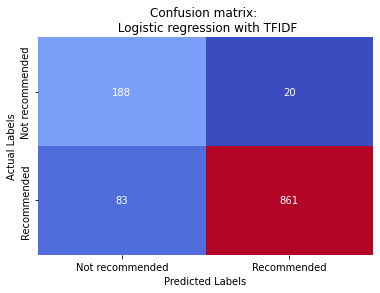

In [11]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(pdf["Recommended IND"],pdf["prediction"])

import seaborn as sns
ax=sns.heatmap(cm, annot=True, fmt="d",cbar=False, cmap="coolwarm")
ax.set_title("Confusion matrix: \n Logistic regression with TFIDF")
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('Actual Labels')
ax.yaxis.set_ticklabels(['Not recommended', 'Recommended'])
ax.xaxis.set_ticklabels(['Not recommended', 'Recommended'])

In [12]:
from sklearn.metrics import classification_report
print(start+"Classification report:"+end)
print(classification_report(pdf["Recommended IND"],pdf["prediction"],target_names=["Not recommended","Recommended"]))

Classification report:
                 precision    recall  f1-score   support

Not recommended       0.69      0.90      0.78       208
    Recommended       0.98      0.91      0.94       944

       accuracy                           0.91      1152
      macro avg       0.84      0.91      0.86      1152
   weighted avg       0.93      0.91      0.91      1152



In [13]:
auc_lr = binary_evaluator.evaluate(predictions_lr, {binary_evaluator.metricName: "areaUnderROC"}) #https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.mllib.evaluation.BinaryClassificationMetrics.html
aucPR_lr = binary_evaluator.evaluate(predictions_lr, {binary_evaluator.metricName: "areaUnderPR"})

print('Area under the receiver operating characteristic (ROC) curve = {:.4f}\nArea under the precision-recall curve                        = {:.4f}'.format(auc_lr,aucPR_lr))

Area under the receiver operating characteristic (ROC) curve = 0.9556
Area under the precision-recall curve                        = 0.9895
